**Connect Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


**Set up run path**

In [2]:
import zipfile
import os
import sys

In [3]:
curr_path = "/content/gdrive/MyDrive/ERA_V1/era_v1_session17"
os.chdir(curr_path)
cwd = os.getcwd()
cwd

'/content/gdrive/MyDrive/ERA_V1/era_v1_session17'

**Install libraries**

In [4]:
!pip install --quiet "torchinfo" "seaborn" "pytorch-lightning" "torchmetrics" "lightning-bolts" "torchtext" "datasets" "tokenizers" "transformers"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.7 MB/s eta 0:00:00


In [ ]:
# Setup data
# zip_path = "pizza_steak_sushi.zip"
# if not os.path.exists("vit_data"):
#     os.makedirs("vit_data", mode=0o777)
# directory_to_extract_to = "vit_data"
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(directory_to_extract_to)
# os.listdir('vit_data')

**Import libraries**

In [5]:
import matplotlib.pyplot as plt
import torch
import torchvision
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from torchvision import transforms

# user scripts
from transformer_model_scripts.vit_utils import data_setup, engine, utils
from transformer_model_scripts.transformer_models import ViT
from transformer_model_scripts.vit_utils.utils import plot_loss_curves


from torch import nn
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

device = "cuda" if torch.cuda.is_available() else "cpu"


**Data loaders and Transforms**

In [6]:
image_path = "/content/gdrive/MyDrive/ERA_V1/era_v1_session17/vit_data/pizza_steak_sushi"
train_dir = image_path + "/train"
test_dir = image_path + "/test"

# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


**Display a sample image**

(-0.5, 223.5, 223.5, -0.5)

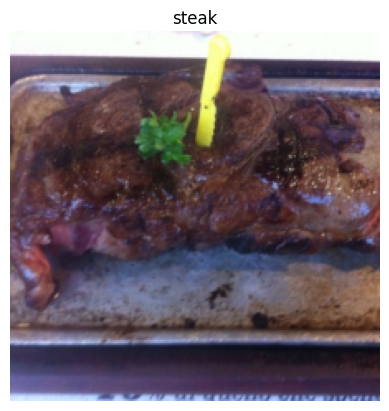

In [7]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

# Plot image with matplotlib
# rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)


**Pre-process image into patches and create embeddings**

In [9]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")


Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [10]:
# Create a random tensor with same shape as a single image
vit_random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit_model = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit_model(vit_random_image_tensor)

tensor([[-0.7091,  0.9771, -0.8540]], grad_fn=<AddmmBackward0>)

**Display model summary**

In [11]:
from torchinfo import summary

# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit_model,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                         [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                                [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                           [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                          [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                                [32, 197, 768]       [32, 197, 768]       --                   True
│    └─EncoderBlock (0)                                      

In [12]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
vit_optimizer = torch.optim.Adam(params=vit_model.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
vit_loss_fn = torch.nn.CrossEntropyLoss()

# Train the model and save the training results to a dictionary
vit_results = engine.train(model=vit_model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=vit_optimizer,
                       loss_fn=vit_loss_fn,
                       epochs=4,
                       device=device)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.9039 | train_acc: 0.2539 | test_loss: 1.7400 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.3592 | train_acc: 0.3125 | test_loss: 2.3562 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.4155 | train_acc: 0.3125 | test_loss: 1.2441 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.2116 | train_acc: 0.2422 | test_loss: 1.0625 | test_acc: 0.5417


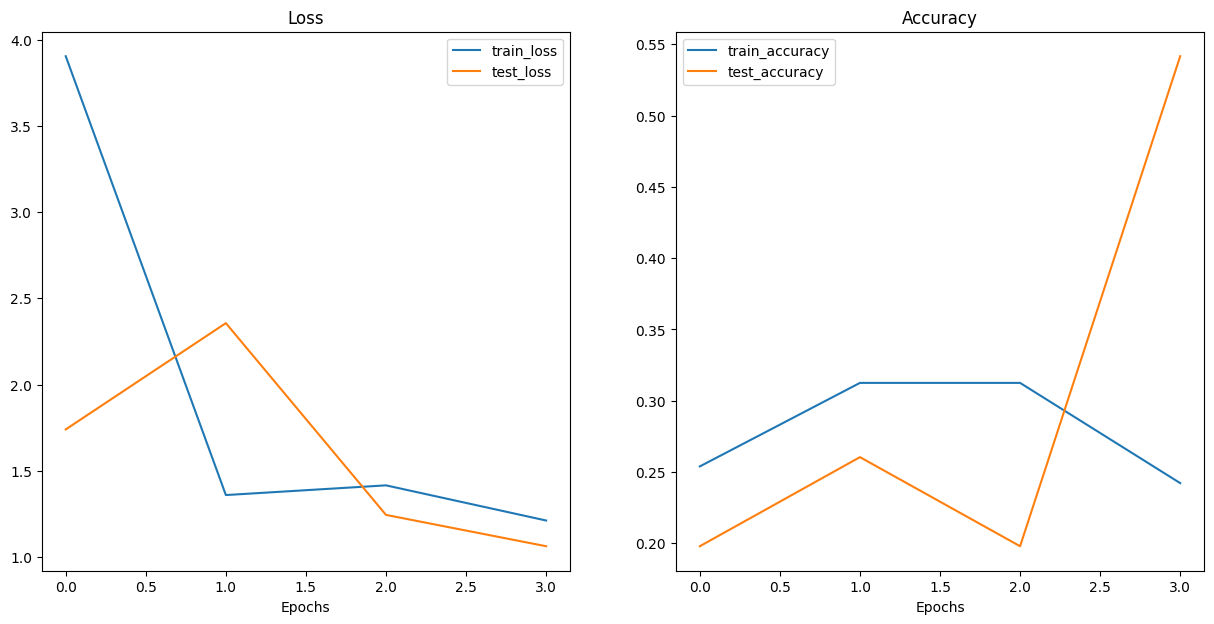

In [13]:
# Plot our ViT model's loss curves
plot_loss_curves(vit_results)

In [14]:
# 1. Get pretrained weights for ViT-Base
vit_pretrained_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
vit_pretrained = torchvision.models.vit_b_16(weights=vit_pretrained_weights).to(device)

# 3. Freeze the base parameters
for parameter in vit_pretrained.parameters():
    parameter.requires_grad = False

# set vit_pretrained heads
vit_pretrained.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)



Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 64.5MB/s]


In [ ]:
# uncomment for model output
# vit_pretrained

In [15]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=vit_pretrained,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [18]:
# Get automatic transforms from pretrained ViT weights
vit_pretrained_transforms = vit_pretrained_weights.transforms()
print(vit_pretrained_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [19]:
# Setup dataloaders
# NOTE: If we had more samples, the batch_size can be increased as discussed
# here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)
(train_dataloader_pretrained, test_dataloader_pretrained,
 class_names) = data_setup.create_dataloaders(train_dir=train_dir,
                                              test_dir=test_dir,
                                              transform=vit_pretrained_transforms,
                                              batch_size=32)


In [20]:
# Create optimizer and loss function
vit_pre_optimizer = torch.optim.Adam(params=vit_pretrained.parameters(),
                             lr=1e-3)
vit_pre_loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
vit_pretrained_results = engine.train(model=vit_pretrained,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=vit_pre_optimizer,
                                      loss_fn=vit_pre_loss_fn,
                                      epochs=3,
                                      device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7178 | train_acc: 0.7656 | test_loss: 0.5087 | test_acc: 0.8883
Epoch: 2 | train_loss: 0.3258 | train_acc: 0.9375 | test_loss: 0.3512 | test_acc: 0.8987
Epoch: 3 | train_loss: 0.2003 | train_acc: 0.9492 | test_loss: 0.2675 | test_acc: 0.8778


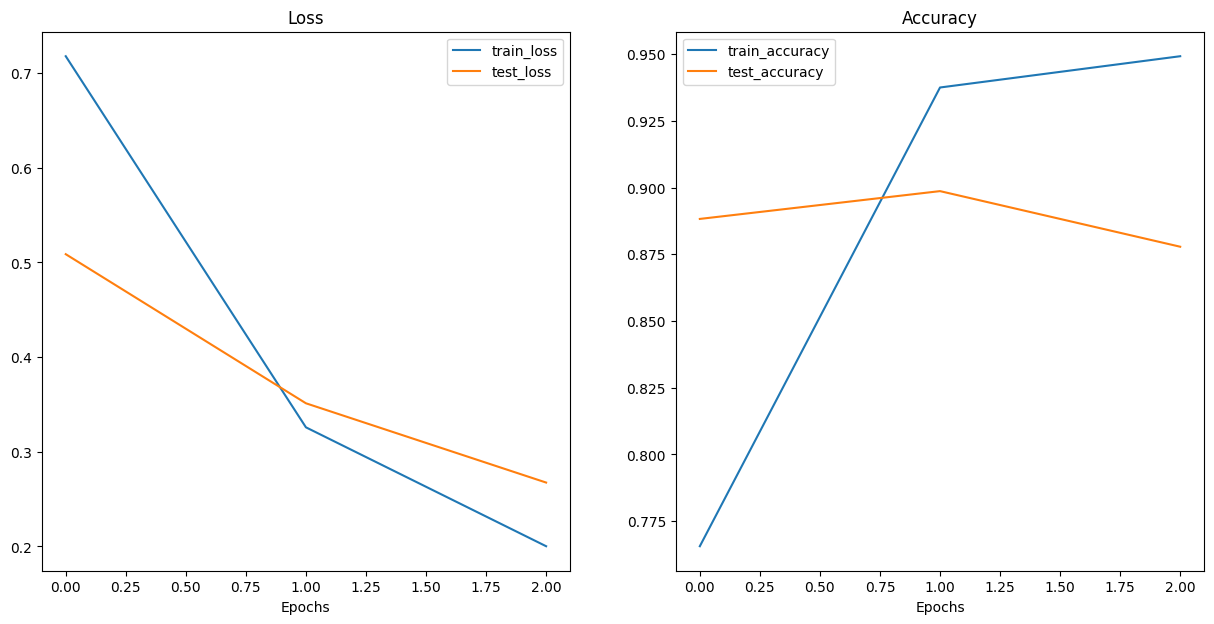

In [21]:
plot_loss_curves(vit_pretrained_results)

In [22]:
# Save the model
utils.save_model(model=vit_pretrained,
                 target_dir="models",
                 model_name="v1_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/v1_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [23]:
from pathlib import Path
import requests

In [24]:
# Get the model size in bytes then convert to megabytes
vit_pretrained_model_size = Path("models/v1_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {vit_pretrained_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


Downloading...


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


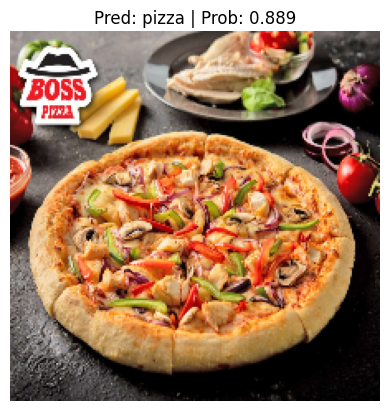

In [25]:
# download sample custom image
with open("download.jpeg", "wb") as f:
    # When downloading from GitHub, need to use the "raw" file link
    request = requests.get("https://www.boss-pizza.co.uk/site/assets/images/uploads/2_3_5c232a9d83be_o.jpg")
    print(f"Downloading...")
    f.write(request.content)

# Predict on custom image
utils.pred_and_plot_image(model=vit_pretrained,
                    image_path="download.jpeg",
                    transform=transforms.Resize((IMG_SIZE, IMG_SIZE)),
                    class_names=class_names)